In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Physical Parameters
T_amb=27.0
T_o=250.0
k=0.45


In [ ]:
#define the neural network
def create_model():
  model={
      'dense1':tf.keras.layers.Dense(50,activation='tanh'),
      'dense2':tf.keras.layers.Dense(50,activation='tanh'),
      'dense3':tf.keras.layers.Dense(50,activation='tanh'),
      'output_layers':tf.keras.layers.Dense(1,dtype='float32')
  }
  return model


In [ ]:
def call_model(model,t):
  t=model['dense1'](t)
  t=model['dense2'](t)
  t=model['dense3'](t)
  t=model['output_layers'](t)
  return t

In [ ]:
#definition of the differential equation
def pde(t,model):
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(t)
    T_pred=call_model(model,t)
    T_t=tape.gradient(T_pred,t)
  del tape
  return T_t-k*(T_amb-T_pred)


In [ ]:
#define the loss functions
def loss(model,t,t_ic,T_ic):
  f=pde(t,model)
  loss_pde=tf.reduce_mean(tf.square(f))
  T_ic_pred=call_model(model,t_ic)
  loss_ic=tf.reduce_mean(tf.square(T_ic_pred-T_ic))
  return loss_pde+loss_ic


In [ ]:
def train_step(model, t, t_ic, T_ic, optimizer):
    with tf.GradientTape() as tape:
        loss_value = loss(model, t, t_ic, T_ic)

    # Collect all trainable variables (flattened)
    variables = []
    for layer in model.values():
        for var in layer.trainable_variables:
            variables.append(var)

    # Compute gradients
    grads = tape.gradient(loss_value, variables)

    # Apply gradients
    optimizer.apply_gradients(zip(grads, variables))

    return loss_value


In [ ]:
#generating the training data
t_train=np.linspace(0,10,100).reshape(-1,1)
t_train=tf.convert_to_tensor(t_train,dtype=tf.float32)


In [ ]:
#Intial conditions data
t_ic=np.array([[0.0]],dtype=np.float32)
T_ic=np.array([[T_o]],dtype=np.float32)
t_ic=tf.convert_to_tensor(t_ic,dtype=tf.float32)
T_ic=tf.convert_to_tensor(T_ic,dtype=tf.float32)


In [ ]:
#define the PINN model
model=create_model()

In [ ]:
#defien the optimizer with a learning rate scheduler
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=500,
    decay_rate=0.95

 )
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
#train the model
epochs=15000
for epoch in range(epochs):
  loss_value=train_step(model,t_train,t_ic,T_ic,optimizer)
  if epoch%500==0:
    print(f"Epoch{epoch}:Loss={loss_value.numpy()}")


Epoch0:Loss=62647.015625
Epoch500:Loss=45703.28515625
Epoch1000:Loss=36864.8359375
Epoch1500:Loss=30013.5078125
Epoch2000:Loss=24648.328125
Epoch2500:Loss=20447.36328125
Epoch3000:Loss=17175.00390625
Epoch3500:Loss=14650.2734375
Epoch4000:Loss=12729.8671875
Epoch4500:Loss=11297.380859375
Epoch5000:Loss=5593.068359375
Epoch5500:Loss=3901.3427734375
Epoch6000:Loss=2695.84912109375
Epoch6500:Loss=1825.8232421875
Epoch7000:Loss=1205.6865234375
Epoch7500:Loss=774.7872314453125
Epoch8000:Loss=485.13995361328125
Epoch8500:Loss=236.94068908691406
Epoch9000:Loss=111.0106201171875
Epoch9500:Loss=46.42770004272461
Epoch10000:Loss=16.571290969848633
Epoch10500:Loss=4.8156304359436035
Epoch11000:Loss=1.078102946281433
Epoch11500:Loss=0.17557662725448608
Epoch12000:Loss=0.08020201325416565
Epoch12500:Loss=0.0024843974970281124
Epoch13000:Loss=0.08143245428800583
Epoch13500:Loss=0.0006820980343036354
Epoch14000:Loss=0.0005321446224115789
Epoch14500:Loss=0.0004561732057482004


In [ ]:
#Predict the colution
t_test=np.linspace(0,10,1000).reshape(-1,1)
t_test=tf.convert_to_tensor(t_test,dtype=tf.float32)
T_pred=call_model(model,t_test).numpy()

In [ ]:
#Analytical solution
T_true=T_amb+(T_o-T_amb)*np.exp(-k*t_test)

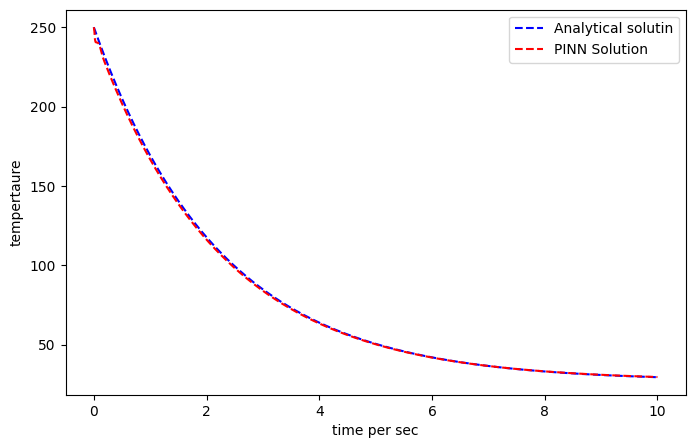

In [ ]:
#plot the results
plt.figure(figsize=(8,5))
plt.plot(t_test,T_true,'b--',label='Analytical solutin')
plt.plot(t_test,T_pred,'r--',label="PINN Solution")
plt.xlabel("time per sec")
plt.ylabel("tempertaure")
plt.legend()
plt.show()